# Proyecto Final Señales y Sistemas 2025 -2

## **Objetivo**: Implementar técnicas de representación en tiempo y frecuencia para el reconocimiento de señales de electroencefalografía (EEG) en tareas de imaginación motora (Motor Imagery)


![eegMI](https://figures.semanticscholar.org/288a54f091264377eccc99a19079c9387d66a78f/3-Figure2-1.png)

Las señales de EEG pueden ser ruidosas debido a diversas fuentes, incluidos artefactos fisiológicos e interferencias electromagnéticas. También pueden variar de persona a persona, lo que dificulta la extracción de características y la comprensión de las señales. Además, esta variabilidad, influenciada por factores genéticos y cognitivos, presenta desafíos para el desarrollo de soluciones independientes del sujeto. 

**Base de datos**: GiGaScience Database [https://gigadb.org/dataset/100295](https://gigadb.org/dataset/100295)

Ver Sección 3.1 en [Multimodal Explainability Using Class Activation Maps and Canonical Correlation for MI-EEG Deep Learning Classification](https://www.mdpi.com/2076-3417/14/23/11208)


## Instalamos las librerias necesarias

## Ejercicio 1
Consultar para qué sirven las siguientes librerías

In [1]:
#!pip install tensorflow==2.15.0
!pip install mne==1.6.0
!pip install braindecode===0.7
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: mne
    Found existing installation: mne 1.9.0
    Uninstalling mne-1.9.0:
      Successfully uninstalled mne-1.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 14.1 MB/s eta 0:00:00
  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-lkvgglv1
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-lkvgglv1
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit d174df9958b6638156dcfe03996a6307e631a6a2
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=32972807 sha256=d16b7f63292a06cf36b5161e8840036198393698b09ff0f92238ed2e37b9f860
  Stored in directory: /tmp/pip-ephem-wheel-cache-da3pq8gx/wheels/8e/66/a

## Importamos algunas librerias necesarias

In [2]:
from scipy.signal import resample
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from gcpds.databases import GIGA_MI_ME
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones necesarias para el preprocesamiento leve de los datos

In [3]:
def load_GIGA(db,
              sbj,
              eeg_ch_names,
              new_fs,
              fs,
              f_bank=None,
              vwt=None,           
              run=None):

    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    #tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    if run == None:
        X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    else:
        X, y = db.get_run(run, classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    #X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        pass#print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    return X, y

def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

#plot eeg   
def plot_eeg(X,tv,ax,channels,esp=2,title=None):
    # X in CH x Samples
    n_canales = X.shape[0]

    for ch in range(n_canales): # canales
            xx = X[ch]
            xx = xx - np.mean(xx)
            xx = xx/np.max(abs(xx))
            ax.plot(tv, xx +(ch * esp), label=channels[ch])  # Desplazamos cada canal para visualización
    ax.set_yticks(range(0, esp * n_canales, esp), channels)  # Etiquetas en el eje Y
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Canales EEG [$\mu$V]")
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlim([min(tv)-0.01,max(tv)+0.01])
    ax.set_ylim([-esp,n_canales*esp+0.01])





      

## Establecemos el protocolo de pruebas y la configuración del montaje EEG

Describir el protocolo de captura de datos y el montaje utilizado


![mi](https://www.mdpi.com/diagnostics/diagnostics-13-01122/article_deploy/html/images/diagnostics-13-01122-g001.png)
![montaje](https://www.mdpi.com/applsci/applsci-14-11208/article_deploy/html/images/applsci-14-11208-g001.png)

In [4]:
channels = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']

areas = {
    'Frontal': ['Fpz', 'AFz', 'Fz', 'FCz'],
    'Frontal Right': ['Fp2','AF4','AF8','F2','F4','F6','F8',],
    'Central Right': ['FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8',],
    'Posterior Right': ['P2','P4','P6','P8','P10','PO4','PO8','O2',],
    #'Central': ['Cz'],
    'Posterior': ['CPz','Pz', 'Cz','POz','Oz','Iz',],
    'Posterior Left': ['P1','P3','P5','P7','P9','PO3','PO7','O1',],
    'Central Left': ['FC1','FC3','FC5','FT7','C1','C3','C5','T7','CP1','CP3','CP5','TP7',],
    'Frontal Left': ['Fp1','AF3','AF7','F1','F3','F5','F7',],
}

arcs = [
    #'hemispheres',
    'areas',
    'channels',
]

## Definimos la ruta y los argumentos para la carga de los datos de EEG

In [5]:
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
#ti = 0
#tf = 7
new_fs = 256.
load_args = dict(db = db,
                 eeg_ch_names = channels,
                 fs = db.metadata['sampling_rate'],
                 #f_bank = np.asarray([[4., 40.]]),
                 #vwt = np.asarray([[ti, tf]]), #2.5 - 5 MI
                 new_fs = new_fs)

## Cargamos los datos según el sujeto que se quiera

Si se quiere cargar los datos de todos los sujetos, aplicar un ciclo que itere la lista de sujetos y de esta forma se cargara uno por uno dependiendo lo que se desee realizar.

Por ejemplo:

for i in sbj:
    X, y = load_GIGA(sbj=sbj, **load_args)

In [6]:
sbj = 5
X, y = load_GIGA(sbj=sbj, **load_args)

Resampling from 512.000000 to 256.000000 Hz.


In [7]:
print(f'X con {X.shape[0]} intentos; {X.shape[1]} canales; {X.shape[2]} muestras No. de segundos {X.shape[2]/new_fs}')

X con 199 intentos; 64 canales; 1792 muestras No. de segundos 7.0


In [8]:
X.shape

(199, 64, 1792)

## Visualización de las señales de EEG en el tiempo

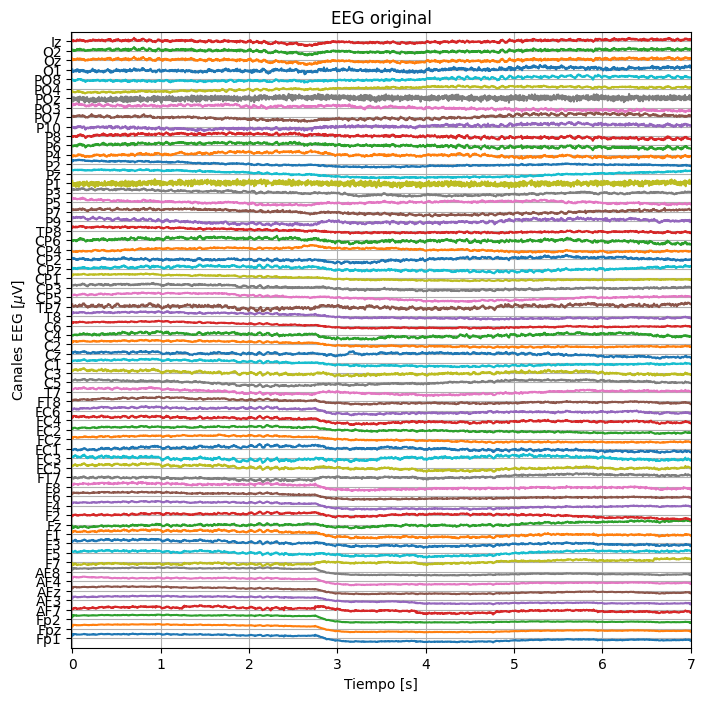

In [9]:
#graficar canales promedio
trial = 0
ti = 0 # ti
tf = 7 # tf
tv = np.arange(ti,tf,1/new_fs)

#Señal cruda
fig,ax = plt.subplots(1,1,figsize=(8,8),sharex = True)
# Graficar cada canal en un subplot banda respectiva

plot_eeg(X[trial],tv,ax=ax,channels=channels,title='EEG original')
plt.show()

# Ejercicio 2

Discuta la gráfica anterior

Nota: Discuta en qué consisten los ritmos cerebrales

![montaje](https://cdn.shopify.com/s/files/1/0348/7053/files/storage.googleapis.com-486681944373284_61cb9936-f6c2-493d-8402-3426d7f5a049_1024x1024.jpg?v=1689309340)



In [10]:
# filtramos trials completos en ritmos cerebrales utilizando filtros IIR


f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
vwt = np.asarray([[ti, tf]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank)

Xrc = np.squeeze(tf_repr.transform(X))

Xrc.shape

(199, 64, 1792, 5)

# Ejercicio 3

Expliqué cómo se calcularon cada una de las 5 dimensiones del arreglo Xrc

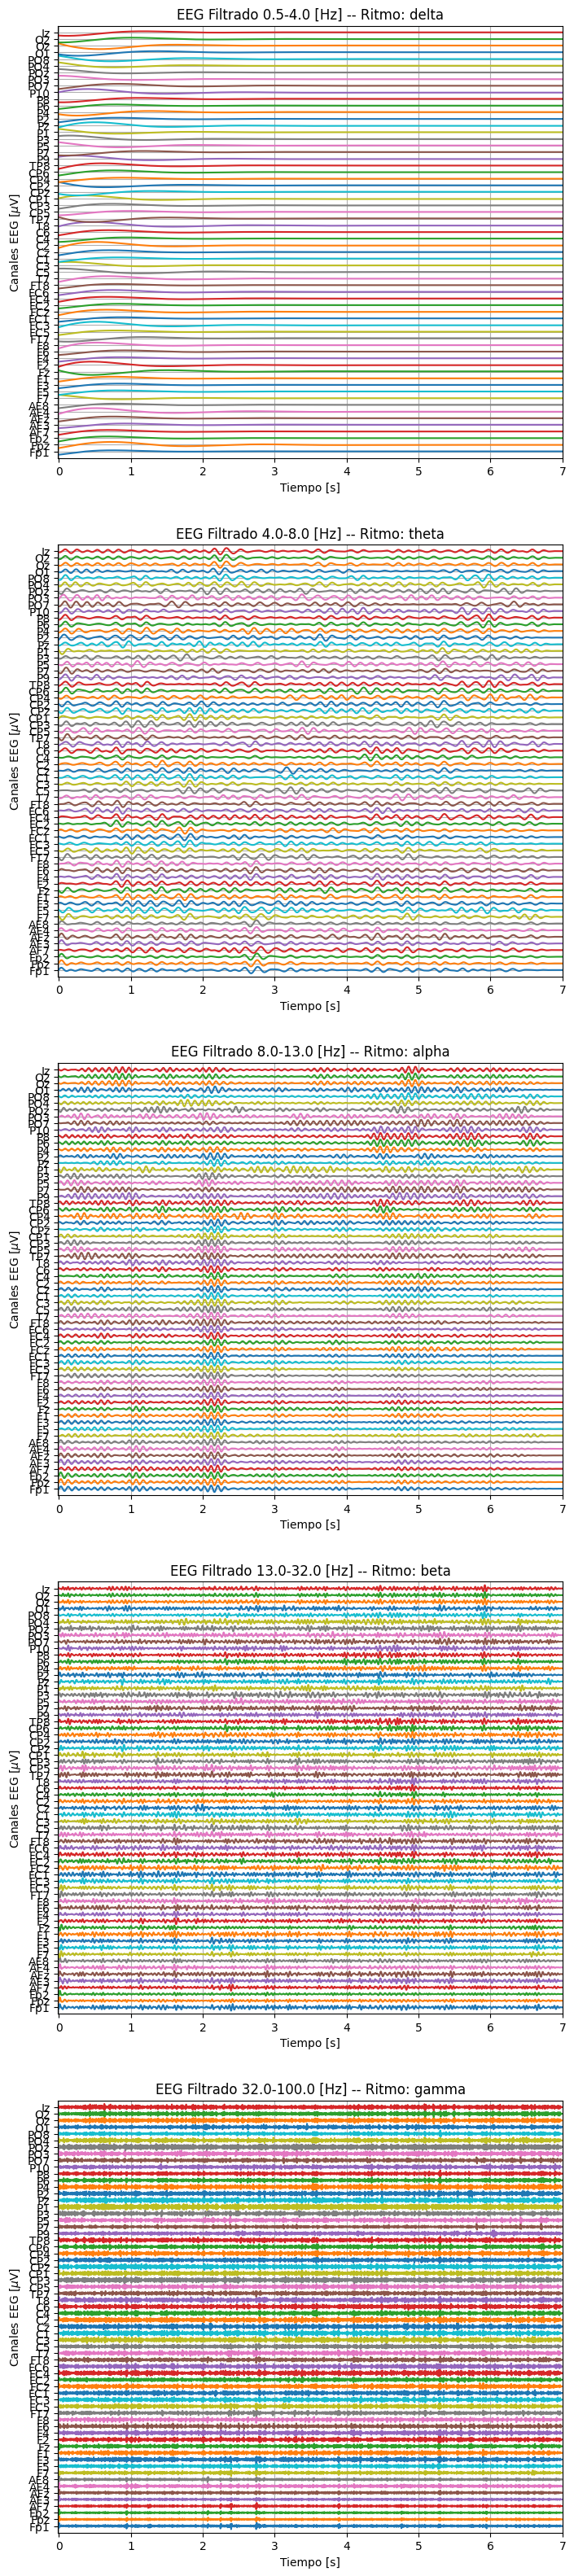

In [11]:
import matplotlib.pyplot as plt

ritmo = ['delta','theta','alpha','beta','gamma']
trial = 0
n_trials, n_canales, n_muestras, n_bands = Xrc.shape  # Simulación de datos

esp = 2 #espaciado canales
fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    plot_eeg(Xrc[trial,:,:,b],tv,ax=ax[b],channels=channels,title=f'EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
plt.show()

## Visualización de las señales de EEG en la frecuencia

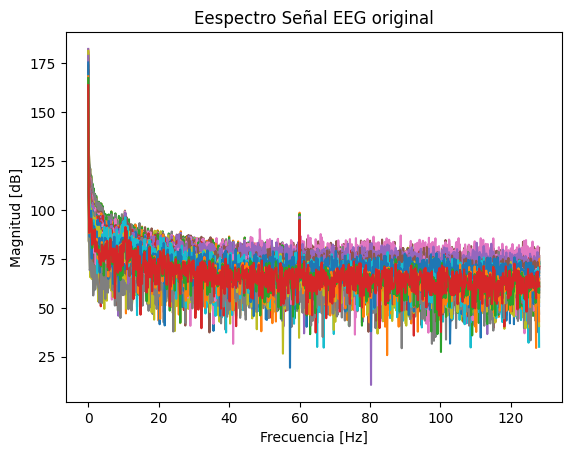

In [12]:
#señal orignal
Xwo = np.fft.rfft(X,axis=-1)
vfreq = np.fft.rfftfreq(X.shape[2],1/new_fs)

Xwo.shape
plt.plot(vfreq,20*np.log10(np.abs(Xwo[trial])).T)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Eespectro Señal EEG original')
plt.show()


## Ejercicio 4

Discuta la gráfica anterior

In [13]:
#espectro señales filtradas
Xwb = np.fft.rfft(Xrc,axis=2)

Xwb.shape

(199, 64, 897, 5)

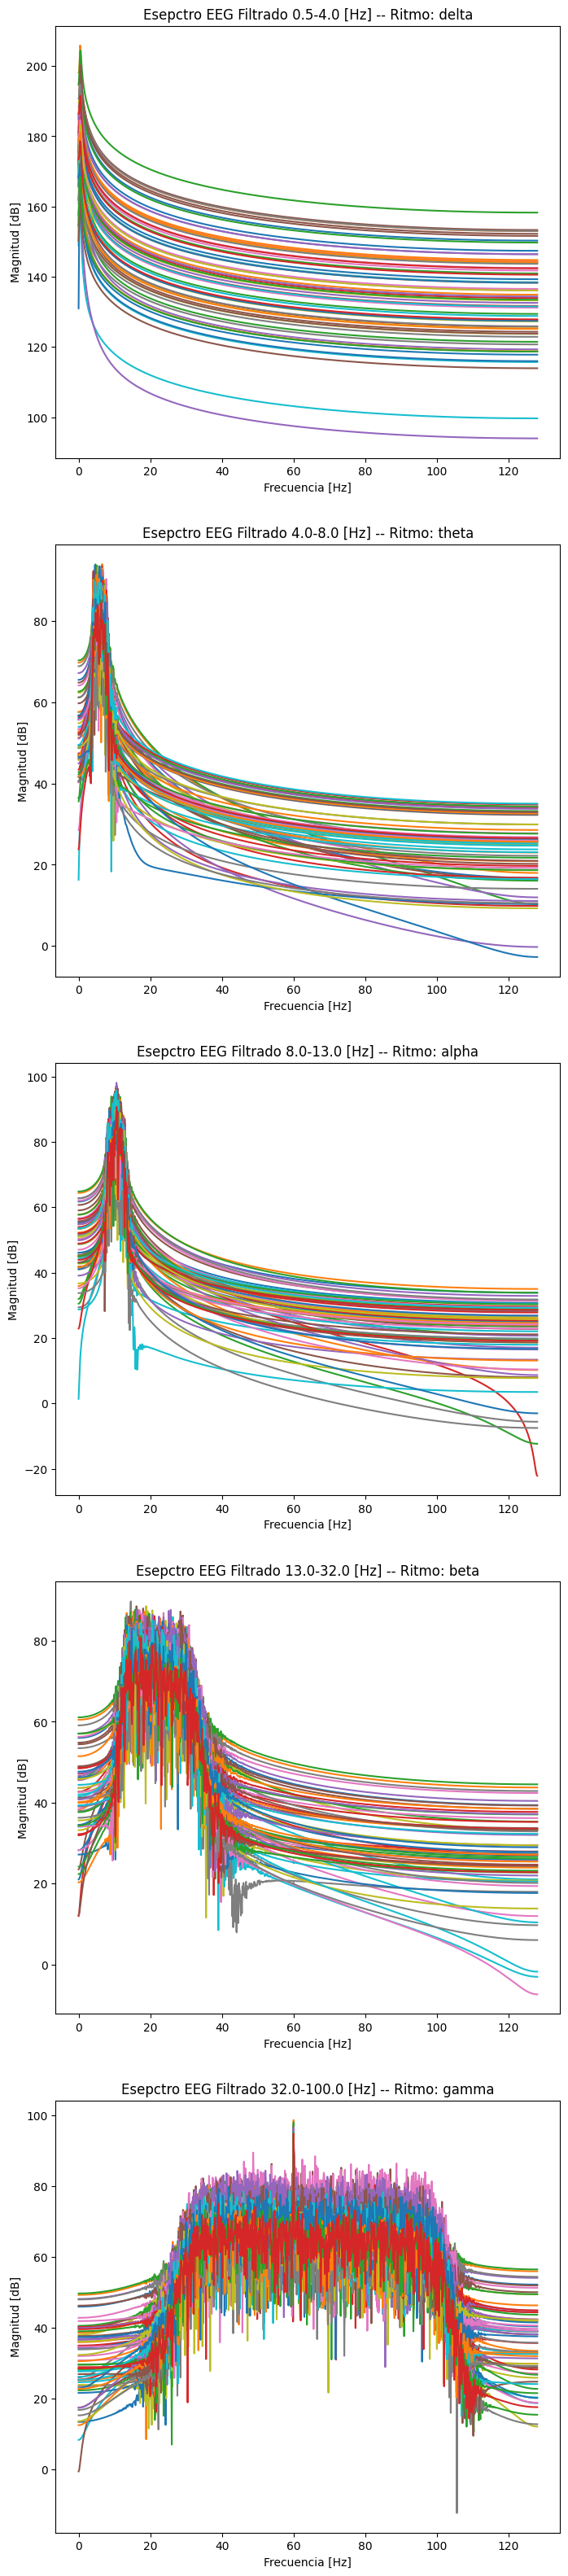

In [14]:
#espectro señales filtradas por bandas - ritmos cerebrales

fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    ax[b].plot(vfreq,20*np.log10(np.abs(Xwb[trial,:,:,b])).T)
    ax[b].set_xlabel('Frecuencia [Hz]')
    ax[b].set_ylabel('Magnitud [dB]')
    ax[b].set_title(f'Esepctro EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
    
plt.show()

## Ejercicio 5

Discuta las gráficas

## Visualización de espectrogramas

Consultar qué es la Short Time Fourier Transform



(199, 64, 65, 29)


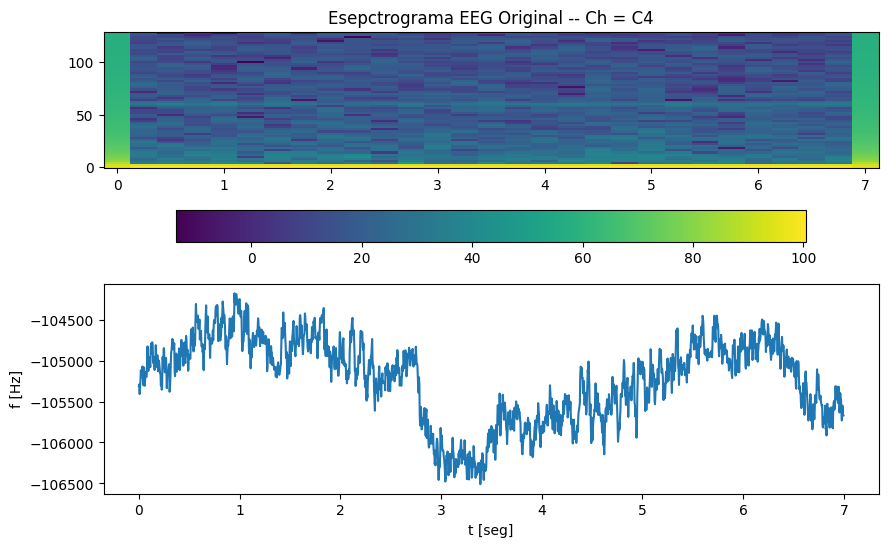

In [15]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
from scipy.signal import stft #
nperseg = 0.5*new_fs#longitud ventas en muestras
vfs,t,Xstft = stft(X,fs=new_fs,nperseg=nperseg,axis=2)
Xstft = 20*np.log10(abs(Xstft))

#graficar stft para un trial y un canal
trail = 0
chi = channels.index('C4')

fig, ax = plt.subplots(2, 1,figsize=(10,6))

ax[1].plot(tv,X[trail,chi,:])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstft[trail,chi])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Original -- Ch = {channels[chi]}')
print(Xstft.shape)

(199, 64, 65, 5, 29)


Text(0.5, 1.0, 'Esepctrograma EEG Filtrado 8.0-13.0 [Hz] -- Ritmo: alpha -- Ch = C4')

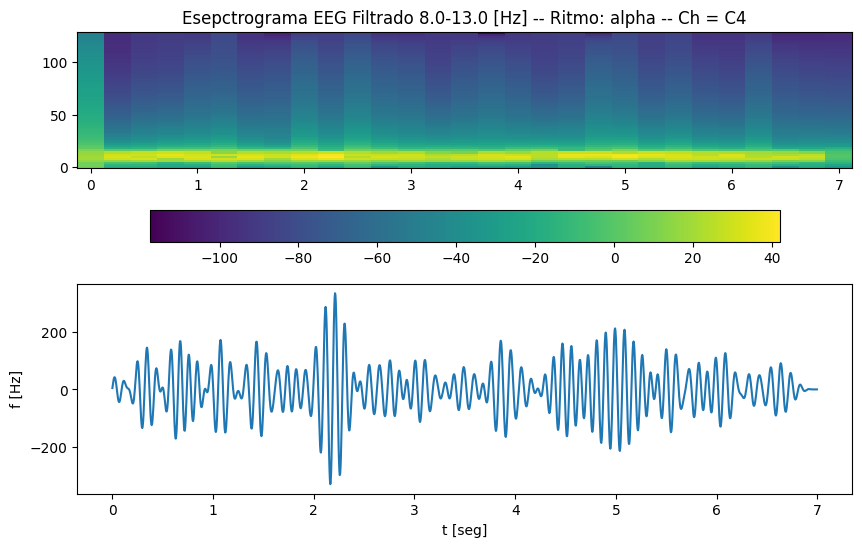

In [16]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
b = 2
vfs,t,Xstftb = stft(Xrc,fs=new_fs,nperseg=nperseg,axis=2)
Xstftb = 20*np.log10(abs(Xstftb))

print(Xstftb.shape)


fig, ax = plt.subplots(2, 1,figsize=(10,6))
ax[1].plot(tv,Xrc[trail,chi,:,b])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstftb[trail,chi,:,b,:])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]} -- Ch = {channels[chi]}')


# Ejercicio 6

Presente las gráficas de stft para distintos canales en los 5 ritmos cerebrales y discuta.

## Visualización de señales EEG sobre montaje 10-20

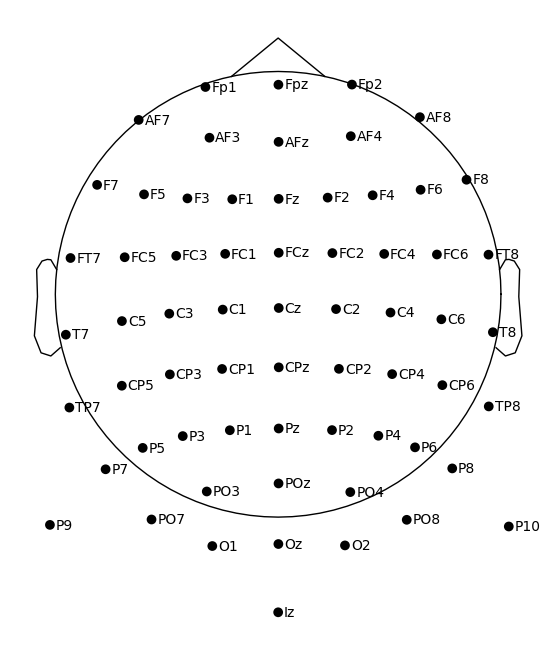

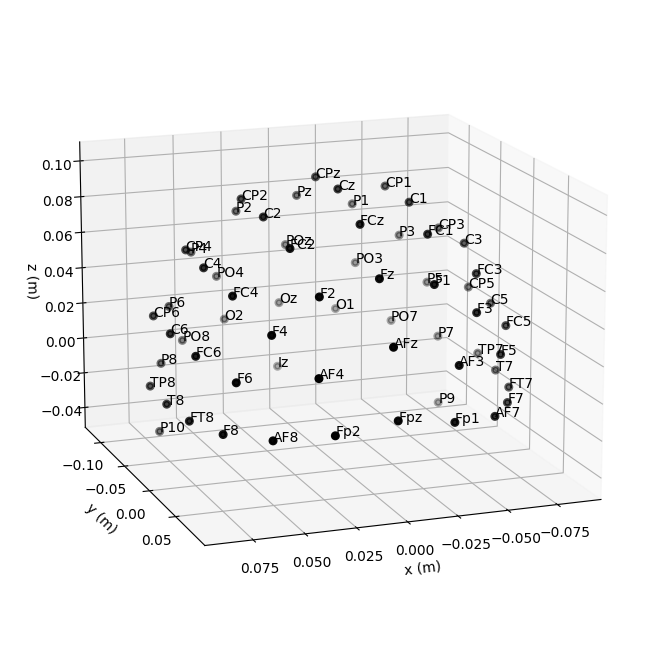

In [17]:
import mne

# Cargar el montaje estándar
easycap_montage = mne.channels.make_standard_montage("standard_1020")


# Crear un montaje personalizado con los electrodos seleccionados
custom_pos = {ch: easycap_montage.get_positions()["ch_pos"][ch] for ch in channels}
custom_montage = mne.channels.make_dig_montage(ch_pos=custom_pos, coord_frame="head")

# Mostrar el montaje personalizado
custom_montage.plot(show_names=True)
fig = custom_montage.plot(kind="3d", show_names=True, show=False)
fig.gca().view_init(azim=70, elev=15)  # Ajustar la vista 3D

In [18]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-72d985r0
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-72d985r0
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit 162dbeac141a7472d3b0bd7f005932241b4663a5
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.7 MB/s eta 0:00:00
  Created wheel for gcpds-visualizations: filename=gcpds_visualizations-0.6-py3-none-any.whl size=12439 sha256=f623b355ba8e602d203cecb8091c1222660ed3ecfa7f9d602e5c01cdd058751a
  Stored in directory: /tmp/pip-ephem-wheel-cache-m65zbv26/wheels/fa/f8/e8/78c4b4940a8349e29d9199eee5e3c5f526123608864b3834af
Successfully built gcpds-visualizations


# Topomaps

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


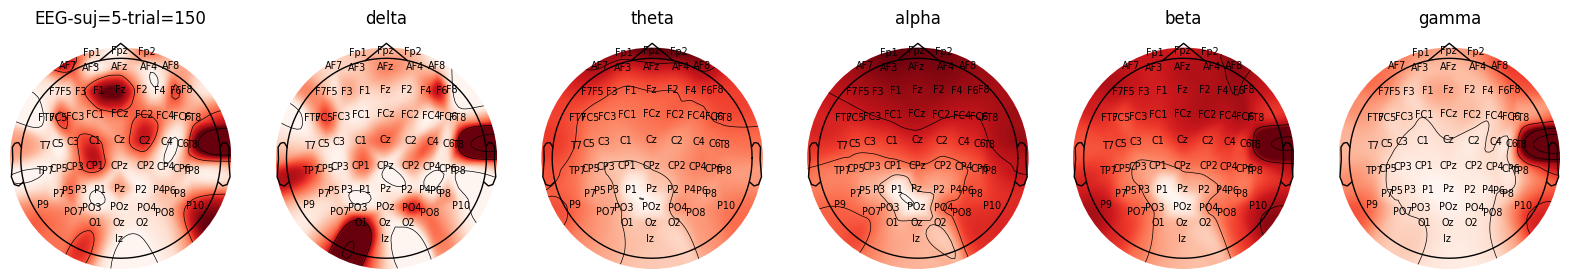

In [19]:
from gcpds.visualizations.topoplots import topoplot


trial = 150
vec_topo_o = abs(X[trial,:]).mean(axis=-1)
vec_topo_b = abs(Xrc[trial,:,:,:]).mean(axis=1)


fig,ax = plt.subplots(1,6,figsize=(20,10))
topoplot(vec_topo_o, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[0],show=False,vlim=(min(vec_topo_o), max(vec_topo_o)))

for b in range(f_bank.shape[0]):
    vec_ = vec_topo_b[:,b]
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[b+1],show=False,vlim=(min(vec_), max(vec_)))
    ax[b+1].set_title(ritmo[b])    

ax[0].set_title(f'EEG-suj={sbj}-trial={trial}')    

plt.show()

## Ejercicio 7

Discuta

## Common Spatial Patterns

Consulté qué son los Common Spatial Patterns (CSP) y su aplicación al procesado de señales EEG

In [20]:
import mne
from mne.decoding import CSP

# Instancia del objeto CSP
n_components = 2
csp = CSP(n_components=n_components, log= True, transform_into='average_power')
# Ajuste y transformación de los datos
csp_data = csp.fit_transform(X.astype(np.float64), y)

CSP Transformado Shape: (199, 2)


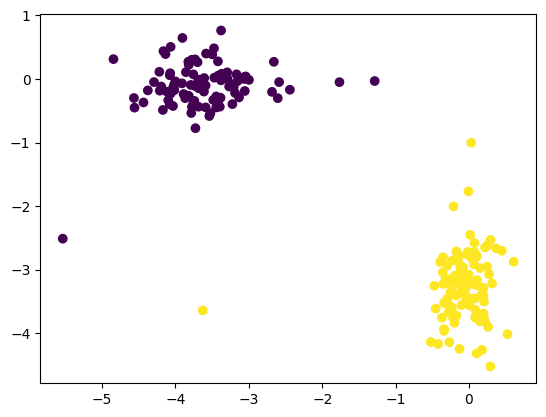

In [21]:
print("CSP Transformado Shape:", csp_data.shape)
plt.scatter(csp_data[:,0],csp_data[:,1],c=y)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


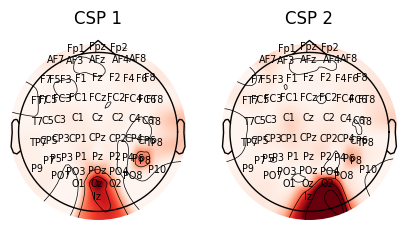

In [22]:
#EEG original
fig,ax = plt.subplots(1,n_components,figsize=(5,5))
for cc in range(n_components):
    vec_ = np.abs(csp.filters_[cc])
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[cc],show=False,vlim=(min(vec_), max(vec_)))
    ax[cc].set_title(f'CSP {cc+1}') 


In [23]:
#lectura de datos
sbj = 14
X, y = load_GIGA(sbj=sbj, **load_args)

f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
vwt = np.array([[0.25, 1.75],[1.5,3],[2.75,4.25],[4,5.5],[5.25,6.75]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank,vwt=vwt)
X_ = np.squeeze(tf_repr.transform(X))
X_.shape

Resampling from 512.000000 to 256.000000 Hz.


(200, 64, 384, 5, 5)

In [24]:
# csp por ventanas y ritmos
# Definir las dimensiones del arreglo
ritmos_ = f_bank.shape[0] 
ventanas_ = vwt.shape[0]
n_comp = 2
# Inicializar el arreglo vacío con listas anidadas
csp_M = [[None for _ in range(ventanas_)] for _ in range(ritmos_)]
csp_filters_ = np.zeros((ritmos_,ventanas_,X_.shape[1],X_.shape[1])) #ritmos ventanas Ch
Xcsp_ = np.zeros((X_.shape[0],n_comp,ritmos_,ventanas_))

for i in range(ritmos_):
    for j in range(ventanas_):
        print(f'CSP ritmo {f_bank[i]} -- ventana {vwt[j]}...')
        csp_M[i][j] =  CSP(n_components=n_comp, log= True, transform_into='average_power')
        Xcsp_[:,:,i,j] = csp.fit_transform(X_[:,:,:,j,i].astype(np.float64), y)
        csp_filters_[i,j,:] = np.abs(csp.filters_) 

CSP ritmo [0.5 4. ] -- ventana [0.25 1.75]...
CSP ritmo [0.5 4. ] -- ventana [1.5 3. ]...
CSP ritmo [0.5 4. ] -- ventana [2.75 4.25]...
CSP ritmo [0.5 4. ] -- ventana [4.  5.5]...
CSP ritmo [0.5 4. ] -- ventana [5.25 6.75]...
CSP ritmo [4. 8.] -- ventana [0.25 1.75]...
CSP ritmo [4. 8.] -- ventana [1.5 3. ]...
CSP ritmo [4. 8.] -- ventana [2.75 4.25]...
CSP ritmo [4. 8.] -- ventana [4.  5.5]...
CSP ritmo [4. 8.] -- ventana [5.25 6.75]...
CSP ritmo [ 8. 13.] -- ventana [0.25 1.75]...
CSP ritmo [ 8. 13.] -- ventana [1.5 3. ]...
CSP ritmo [ 8. 13.] -- ventana [2.75 4.25]...
CSP ritmo [ 8. 13.] -- ventana [4.  5.5]...
CSP ritmo [ 8. 13.] -- ventana [5.25 6.75]...
CSP ritmo [13. 32.] -- ventana [0.25 1.75]...
CSP ritmo [13. 32.] -- ventana [1.5 3. ]...
CSP ritmo [13. 32.] -- ventana [2.75 4.25]...
CSP ritmo [13. 32.] -- ventana [4.  5.5]...
CSP ritmo [13. 32.] -- ventana [5.25 6.75]...
CSP ritmo [ 32. 100.] -- ventana [0.25 1.75]...
CSP ritmo [ 32. 100.] -- ventana [1.5 3. ]...
CSP ritmo [ 

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


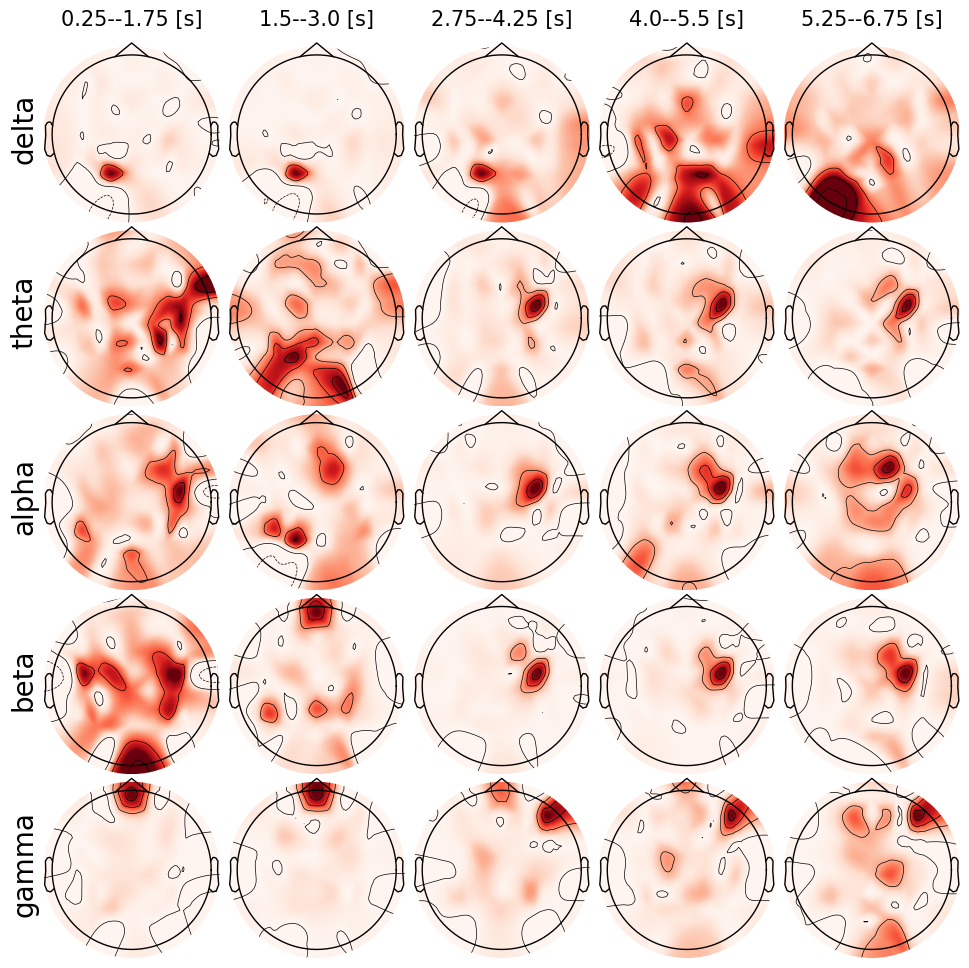

In [25]:
# graficar topomaps
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        vec_ = csp_filters_[i,j,0]
        vec_ = vec_/max(vec_)
        topoplot(vec_, channels, contours=3, cmap='Reds', names=None, sensors=False,ax=ax[i,j],show=False,vlim=(min(vec_), max(vec_)))
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=-0.025,wspace=-0.025)    
plt.show()      

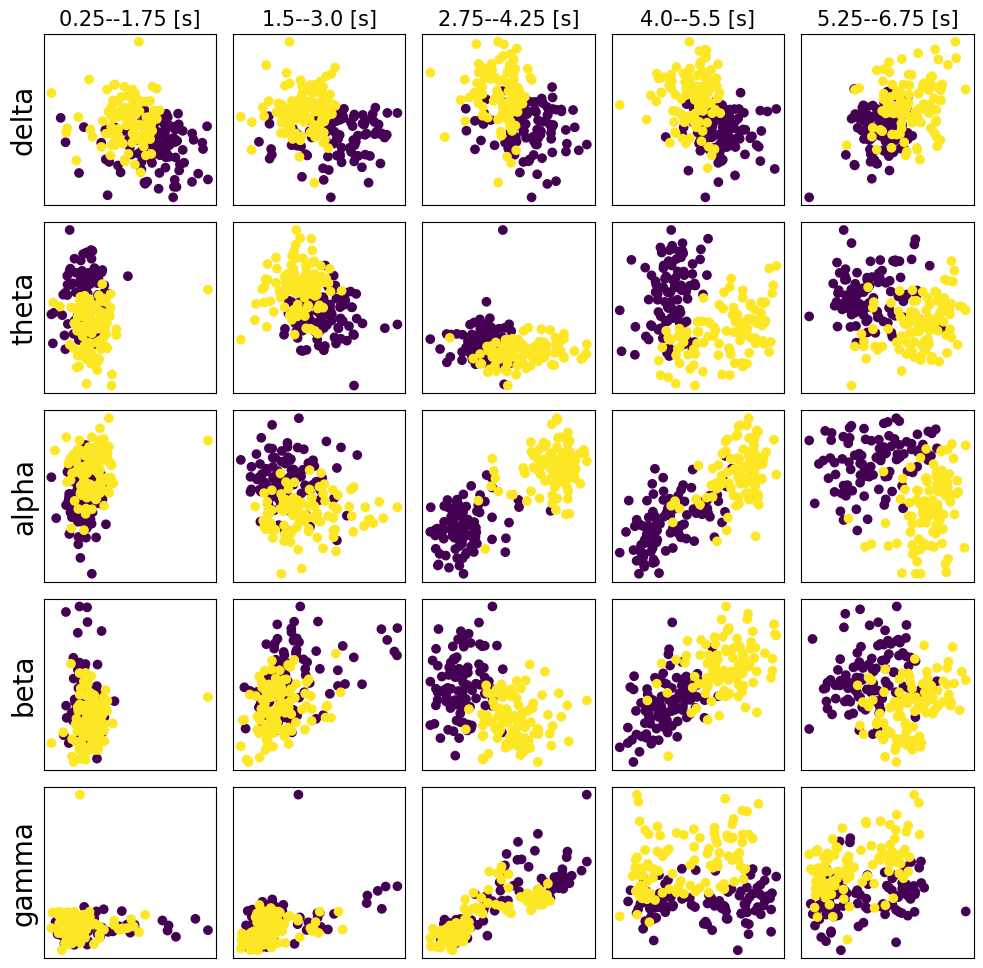

In [26]:
#scatters
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        ax[i,j].scatter(Xcsp_[:,0,i,j],Xcsp_[:,1,i,j],c=y)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=0.1,wspace=0.1)    
plt.show()  